In [3]:
import awkward as ak
import vector
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

import mplhep as hep
plt.style.use(hep.style.CMS)

import xgboost as xgb

In [4]:
def load_all_data(input_loc: str, n_files: int = None, columns: list = None) -> ak.Array:
    """Loads all .parquet files specified by the input. The input can be a list of input_paths, a directory where the files
    are located or a wildcard path.
    Args:
        input_loc : str
            Location of the .parquet files.
        n_files : int
            [default: None] Maximum number of input files to be loaded. By default all will be loaded.
        columns : list
            [default: None] Names of the columns/branches to be loaded from the .parquet file. By default all columns will
            be loaded
    Returns:
        input_data : ak.Array
            The concatenated data from all the loaded files
    """
    if n_files == -1:
        n_files = None
    if isinstance(input_loc, list):
        input_files = input_loc[:n_files]
    elif isinstance(input_loc, str):
        if os.path.isdir(input_loc):
            input_loc = os.path.expandvars(input_loc)
            input_files = glob.glob(os.path.join(input_loc, "*.parquet"))[:n_files]
        elif "*" in input_loc:
            input_files = glob.glob(input_loc)[:n_files]
        else:
            raise ValueError(f"Unexpected input_loc")
    else:
        raise ValueError(f"Unexpected input_loc")
    input_data = []
    for i, file_path in enumerate(input_files):
        print(f"[{i+1}/{len(input_files)}] Loading from {file_path}")
        try:
            input_data.append(load_parquet(file_path, columns=columns))
        except ValueError:
            print(f"{file_path} does not exist")
    if len(input_data) > 0:
        data = ak.concatenate(input_data)
        print("Input data loaded")
    else:
        raise ValueError(f"No files found in {input_loc}")
    return data


def load_parquet(input_path: str, columns: list = None) -> ak.Array:
    """ Loads the contents of the .parquet file specified by the input_path
    Args:
        input_path : str
            The path to the .parquet file to be loaded.
        columns : list
            Names of the columns/branches to be loaded from the .parquet file
    Returns:
        input_data : ak.Array
            The data from the .parquet file
    """
    ret = ak.from_parquet(input_path, columns=columns)
    ret = ak.Array({k: ret[k] for k in ret.fields})
    return ret

In [5]:
vbfhh = load_all_data("samples/samples/selected_hh_vbf/")

[1/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v1_kl2_madgraph_events_0.parquet
[2/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v0_kl1_madgraph_events_2.parquet
[3/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v0_kl1_madgraph_events_1.parquet
[4/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v1_kl1_madgraph_events_0.parquet
[5/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v1_kl1_madgraph_events_1.parquet
[6/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v2_kl1_madgraph_events_0.parquet
[7/7] Loading from samples/samples/selected_hh_vbf/hh_vbf_hbb_htt_kv1_k2v0_kl1_madgraph_events_0.parquet
Input data loaded


# GenPart Matching

In [6]:
vector.register_awkward()

genparts = vbfhh.GenPart
mask_status_23 = genparts.status == 23
genparts_status_23 = genparts[mask_status_23]

mask_pdgid = abs(genparts_status_23.pdgId) < 5
masked_genparts = genparts_status_23[mask_pdgid]


masked_genpart_vecs = ak.zip(
    {
        "pt": masked_genparts.pt,
        "eta": masked_genparts.eta,
        "phi": masked_genparts.phi,
        "mass": masked_genparts.mass,
    },
    with_name="Momentum4D"
)

trainingjets_novec = vbfhh["TrainingJet"]
trainingjet_vecs = ak.zip(
    {
        "pt": vbfhh["TrainingJet"]["pt"],
        "eta": vbfhh["TrainingJet"]["eta"],
        "phi": vbfhh["TrainingJet"]["phi"],
        "mass": vbfhh["TrainingJet"]["mass"],
    },
    with_name="Momentum4D"
)


G1 = masked_genpart_vecs[:,0]
G2 = masked_genpart_vecs[:,1]

In [7]:
G1_deltaRs = G1.deltaR(trainingjet_vecs)
G1_min_deltaR_idx = ak.argmin(G1_deltaRs, axis=1)
trainingjet_loc_idx = ak.local_index(trainingjet_vecs)

G1_mask = trainingjet_loc_idx == G1_min_deltaR_idx
G1_03_deltaRs = G1_deltaRs < 0.3

G1_combined_mask = G1_mask & G1_03_deltaRs

lowest_G1_deltaR_jet = trainingjet_vecs[G1_combined_mask]
lowest_G1_deltaR_novec = trainingjets_novec[G1_combined_mask]

In [8]:
G2_deltaRs = ak.where(~G1_combined_mask, G2.deltaR(trainingjet_vecs), ak.Array([999] * len(trainingjet_vecs))) 
G2_min_deltaR_idx = ak.argmin(G2_deltaRs, axis=1)
trainingjet_loc_idx = ak.local_index(trainingjet_vecs)

G2_mask = trainingjet_loc_idx == G2_min_deltaR_idx
G2_03_deltaRs = G2_deltaRs < 0.3

G2_combined_mask = G2_mask & G2_03_deltaRs

lowest_G2_deltaR_jet = trainingjet_vecs[G2_combined_mask]
lowest_G2_deltaR_novec = trainingjets_novec[G2_combined_mask]

In [9]:
filtered_jets = ak.concatenate([lowest_G1_deltaR_jet, lowest_G2_deltaR_jet], axis=1)
filtered_novec_jets = ak.concatenate([lowest_G1_deltaR_novec, lowest_G2_deltaR_novec], axis=1)

In [10]:
num_parts_in_filtered = ak.num(filtered_jets)
two_part_events = filtered_jets[num_parts_in_filtered == 2]

In [11]:
matched_pairs = ak.where(num_parts_in_filtered == 2, filtered_jets, ak.Array([[]] * len(filtered_jets)))
matched_novec_pairs = ak.where(num_parts_in_filtered == 2, filtered_novec_jets, ak.Array([[]] * len(filtered_jets)))
two_jet_novec_pairs = filtered_novec_jets[num_parts_in_filtered == 2]

In [12]:
sum_matched_jet_vecs = ak.sum(two_part_events, axis=1)
matched_jet_inv_mass = sum_matched_jet_vecs.mass
matched_jet_delta_eta = two_part_events[:, 0].eta - two_part_events[:, 1].eta

# Preselected VBF Jets

In [13]:
vector.register_awkward()

vbf_jet_novec = vbfhh["VBFJet"]
vbf_jet_vecs = ak.zip(
    {
        "pt": vbfhh["VBFJet"]["pt"],
        "eta": vbfhh["VBFJet"]["eta"],
        "phi": vbfhh["VBFJet"]["phi"],
        "mass": vbfhh["VBFJet"]["mass"],
    },
    with_name="Momentum4D"
)

In [14]:
vbf_vecs = vbf_jet_vecs[ak.num(vbf_jet_vecs, axis=1) == 2]

In [15]:
sum_vbf_jet_vecs = ak.sum(vbf_vecs, axis=1)
vbf_jet_invariant_masses = sum_vbf_jet_vecs.mass
vbf_jet_delta_eta = vbf_vecs[:, 0].eta - vbf_vecs[:, 1].eta

# Pairs

In [16]:
num_parts_in_trainingjet = ak.num(trainingjet_vecs, axis=1)
filtered_events = ak.where(num_parts_in_trainingjet > 3, trainingjet_vecs, ak.Array([[]] * len(trainingjet_vecs)))
filtered_events_novec = ak.where(num_parts_in_trainingjet > 3, trainingjets_novec, ak.Array([[]] * len(trainingjets_novec)))

In [17]:
pairs = ak.combinations(filtered_events, 2)
novec_pairs = ak.combinations(filtered_events_novec, 2)
matched_pairs_sum = ak.sum(matched_pairs, axis=1)
matched_pairs_invariant_mass = matched_pairs_sum.mass

In [18]:
invmass = (vector.Array(pairs["0"]) + vector.Array(pairs["1"])).mass

# Loc Idx Array for Matched Jets

In [19]:
trainingjet_loc_idx = ak.local_index(trainingjet_vecs, axis = 1)

In [20]:
lowest_G1_deltaR_idx = trainingjet_loc_idx[G1_combined_mask]
lowest_G2_deltaR_idx = trainingjet_loc_idx[G2_combined_mask]
filtered_jet_idx = ak.concatenate([lowest_G1_deltaR_idx, lowest_G2_deltaR_idx], axis=1)

In [21]:
matched_pairs_idx = ak.where(num_parts_in_filtered == 2, filtered_jet_idx, ak.Array([[]] * len(filtered_jet_idx)))
match_pair_idx = ak.where(num_parts_in_trainingjet > 3, matched_pairs_idx, ak.Array([[]] * len(matched_pairs_idx)))

# Loc Idx Array for Pairs

In [22]:
filtered_events_loc_idx = ak.where(num_parts_in_trainingjet > 3, trainingjet_loc_idx, ak.Array([[]] * len(trainingjet_vecs)))
pairs_idx = ak.combinations(filtered_events_loc_idx, 2)
idx1, idx2 = ak.unzip(pairs_idx)

# Loc Idx Matching

In [23]:
padded_matched_pairs_idx = ak.pad_none(match_pair_idx, 2)

In [24]:
padded_matched_idx1 = padded_matched_pairs_idx[:,0]
padded_matched_idx2 = padded_matched_pairs_idx[:,1]

In [25]:
matched_idx1_bcast, pair_idx1 = ak.broadcast_arrays(padded_matched_idx1, idx1)
matched_idx2_bcast, pair_idx2 = ak.broadcast_arrays(padded_matched_idx2, idx2)

In [26]:
idx_mask1 = matched_idx1_bcast == pair_idx1
idx_mask2 = matched_idx1_bcast == pair_idx2
idx_mask3 = matched_idx2_bcast == pair_idx1
idx_mask4 = matched_idx2_bcast == pair_idx2

In [27]:
comb_mask = idx_mask1 & idx_mask4 | idx_mask2 & idx_mask3

In [28]:
masked_pair_indices = ak.local_index(pairs)
final_indices = masked_pair_indices[comb_mask]

In [29]:
nonone_indices = ak.fill_none(ak.firsts(final_indices), 9999)
idx_mask = nonone_indices == masked_pair_indices

# False Pairs

In [30]:
vec_pairs = pairs[~idx_mask]
novec_pairs2 = novec_pairs[~idx_mask]
vec_pairs_inv_mass = invmass[~idx_mask]

In [31]:
vec1s, vec2s = ak.unzip(vec_pairs) 

v1 = ak.zip( 
    {
        "pt": vec1s.pt, 
        "eta": vec1s.eta, 
        "phi": vec1s.phi, 
        "mass": vec1s.mass
    }, 
    with_name="Momentum4D"
)

v2 = ak.zip(
    {
        "pt": vec2s.pt, 
        "eta": vec2s.eta, 
        "phi": vec2s.phi, 
        "mass": vec2s.mass
    }, 
    with_name="Momentum4D"
)

# Plots

Number of events from the 7 files: 203006. Events containing matched jets (deltaR < 0.3): 73396.
Events containing matched jets (without events with less than 4 jets): 65361.
Events with more than 4 jets: 132123

Number of matched pairs: 73396. 
Number of false pairs: 1207409

# Invariant mass

In [32]:
# 1962 jeti puhul mass neg
# 50 puhul pt pos

In [33]:
ak.flatten(vbfhh.TrainingJet[vbfhh.TrainingJet.mass < 0]).mass

<Array [-0.0802, -1.75, -0.0606, ..., -0.194, -0.0855] type='1962 * float32'>

In [34]:
ak.flatten(vbfhh.TrainingJet[vbfhh.TrainingJet.mass < 0])[ak.flatten(vbfhh.TrainingJet[vbfhh.TrainingJet.mass < 0]).pt > 0][1]

<Record {btagDeepFlavB: 0.00801, ...} type='{btagDeepFlavB: float32, btagDe...'>

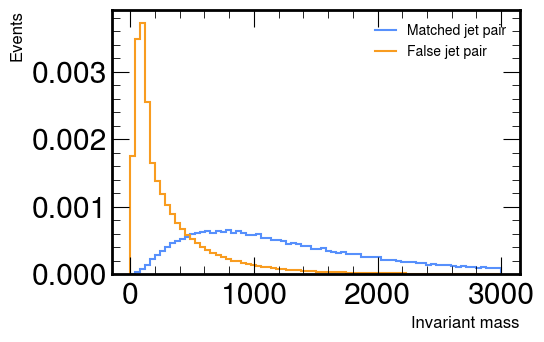

In [34]:
hist1, bins1 = np.histogram(matched_jet_inv_mass, bins = np.linspace(0, 3000, 75))
hist2, bins2 = np.histogram(ak.flatten(vec_pairs_inv_mass), bins = np.linspace(0, 3000, 75))
#hist3, bins3 = np.histogram(vbf_jet_invariant_masses, bins = np.linspace(0, 3000, 75))
fig, ax = plt.subplots(figsize=(6,4))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet invariant mass',
#    density=True,
#)

ax.set_xlabel('Invariant mass', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/01_invariant_mass.png", dpi=150)

# $p_T$

In [35]:
# 1912 juhul trainingjetides pt neg
# sellep abs väärtus igal pool

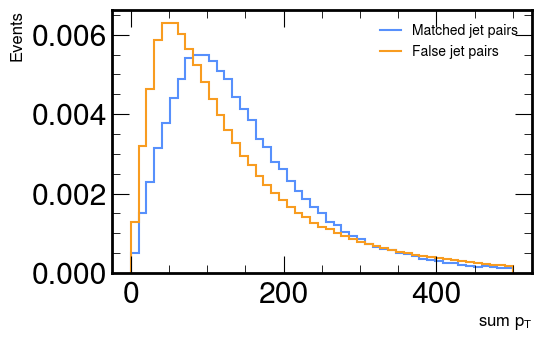

In [36]:
hist1, bins1 = np.histogram(abs((two_part_events[:, 0] + two_part_events[:, 1]).pt), bins = np.linspace(0, 500, 50))
hist2, bins2 = np.histogram(abs(ak.flatten(v1 + v2).pt), bins = np.linspace(0, 500, 50))
fig, ax = plt.subplots(figsize=(6,4))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)


ax.set_xlabel('sum $ p_T$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/02_sum_pt.png", dpi=150)

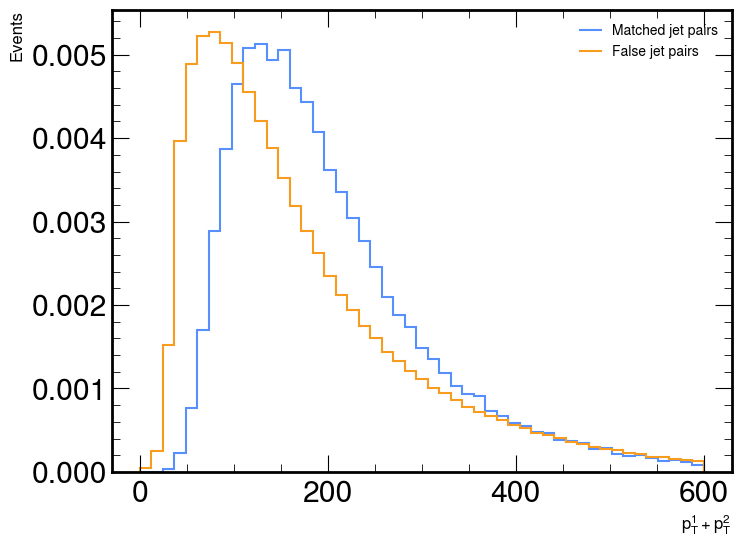

In [37]:
hist1, bins1 = np.histogram(abs(two_part_events[:, 0].pt + two_part_events[:, 1].pt), bins = np.linspace(0, 600, 50))
hist2, bins2 = np.histogram(abs(ak.flatten(v1.pt + v2.pt)), bins = np.linspace(0, 600, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)


ax.set_xlabel('$ p_T^1 + p_T^2$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

In [36]:
matched_jets_max_pt = ak.max(abs(matched_pairs.pt)[ak.num(matched_pairs) > 0], axis=1)
matched_jets_min_pt = ak.min(abs(matched_pairs.pt)[ak.num(matched_pairs) > 0], axis=1)

higher_pt_mask = abs(v1.pt) > abs(v2.pt)
false_pair_max_pt = ak.where(higher_pt_mask, v1, v2)
false_pair_min_pt = ak.where(higher_pt_mask, v2, v1)

In [41]:
import math
math.sqrt(0.292*0.292+7.71*7.71)

7.715527460906351

In [42]:
px = ak.flatten(trainingjet_vecs.px[trainingjet_vecs.pt<0])
py = ak.flatten(trainingjet_vecs.py[trainingjet_vecs.pt<0])
pt = ak.flatten(trainingjet_vecs.pt[trainingjet_vecs.pt<0])
for ip, p in enumerate(px):
    a = round(pt[ip],3)
    b = round(math.sqrt(p*p+py[ip]*py[ip]),3)
    if abs(a)!=b: print(a, b)

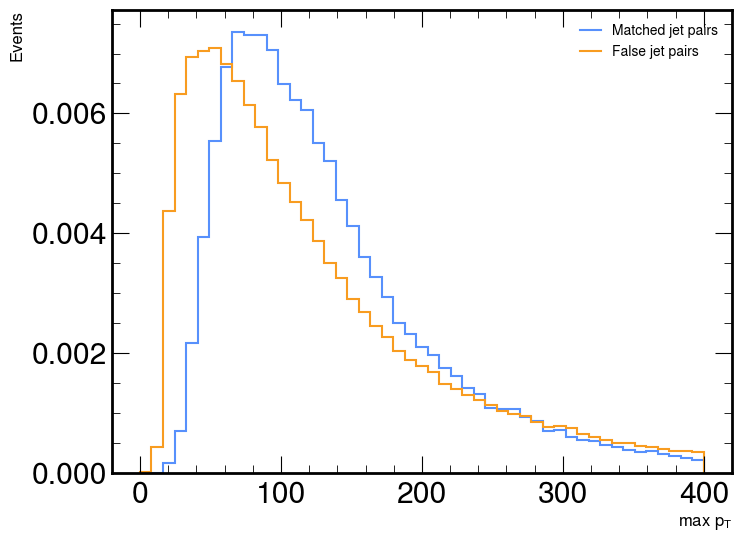

In [43]:
hist1, bins1 = np.histogram(matched_jets_max_pt, bins = np.linspace(0, 400, 50))
hist2, bins2 = np.histogram(ak.flatten(abs(false_pair_max_pt.pt)), bins = np.linspace(0, 400, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

ax.set_xlabel('max $ p_T $', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/04_max_pt.png", dpi=150)

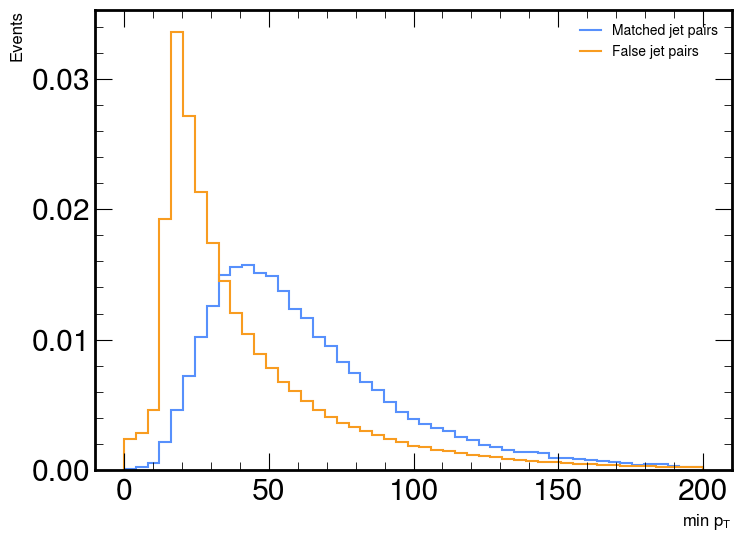

In [44]:
hist1, bins1 = np.histogram(matched_jets_min_pt, bins = np.linspace(0, 200, 50))
hist2, bins2 = np.histogram(ak.flatten(abs(false_pair_min_pt.pt)), bins = np.linspace(0, 200, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

ax.set_xlabel('min $ p_T $', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/05_min_pt.png", dpi=150)

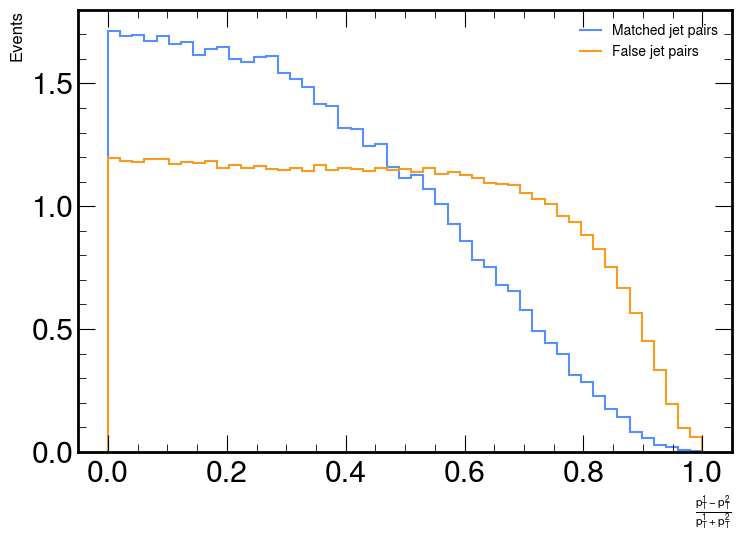

In [46]:
# (pt1 - pt2) / (pt1 + pt2)

hist1, bins1 = np.histogram(abs(two_part_events[:, 0].pt - two_part_events[:, 1].pt)/(two_part_events[:, 0].pt + two_part_events[:, 1].pt), bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(abs(v1.pt - v2.pt)/(v1.pt + v2.pt)), bins = np.linspace(0, 1, 50))
#hist3, bins3 = np.histogram(abs(vbf_vecs[:, 0].pt - vbf_vecs[:, 1].pt)/(vbf_vecs[:, 0].pt + vbf_vecs[:, 1].pt), bins = np.linspace(0, 1, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet',
#    density=True,
#)

ax.set_xlabel('$ \\frac{p_T^1 - p_T^2}{p_T^1 + p_T^2}$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/06_pt.png", dpi=150)

# $\Delta R$

In [37]:
matched_pair_deltaR = two_part_events[:, 0].deltaR(two_part_events[:, 1])
false_pair_deltaR = v1.deltaR(v2)

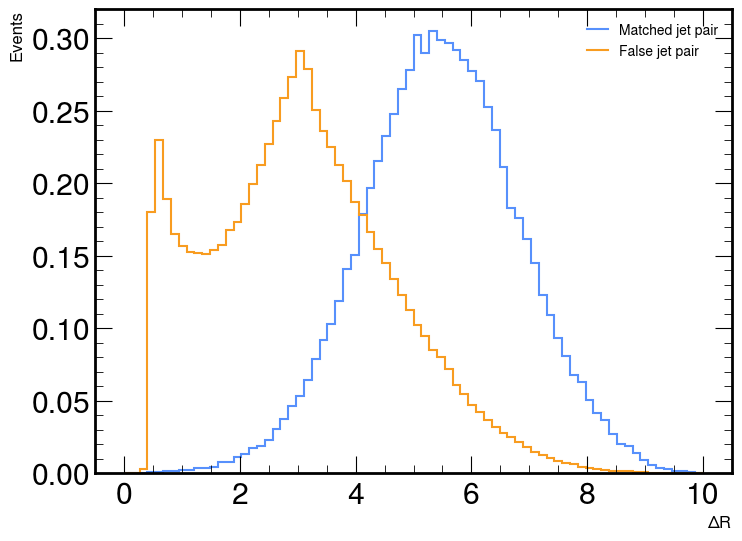

In [48]:
hist1, bins1 = np.histogram(matched_pair_deltaR, bins = np.linspace(0, 10, 75))
hist2, bins2 = np.histogram(ak.flatten(false_pair_deltaR), bins = np.linspace(0, 10, 75))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)


ax.set_xlabel('$\\Delta R$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/07_delta_r.png", dpi=150)

# $ \eta$

In [38]:
trainingjet_pair_delta_eta = v1.deltaeta(v2)

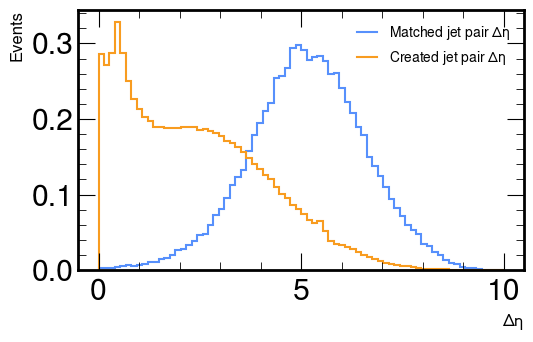

In [50]:
hist1, bins1 = np.histogram(abs(matched_jet_delta_eta), bins = np.linspace(0, 10, 75))
hist2, bins2 = np.histogram(abs(ak.flatten(trainingjet_pair_delta_eta)), bins = np.linspace(0, 10, 75))
#hist3, bins3 = np.histogram(abs(vbf_jet_delta_eta), bins = np.linspace(0, 10, 75))
fig, ax = plt.subplots(figsize=(6,4))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair $ \\Delta \\eta$',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='Created jet pair $ \\Delta \\eta$',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet $\\Delta \\eta$',
#    density=True,
#)

ax.set_xlabel('$\\Delta \\eta$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/03_delta_eta.png", dpi=150)


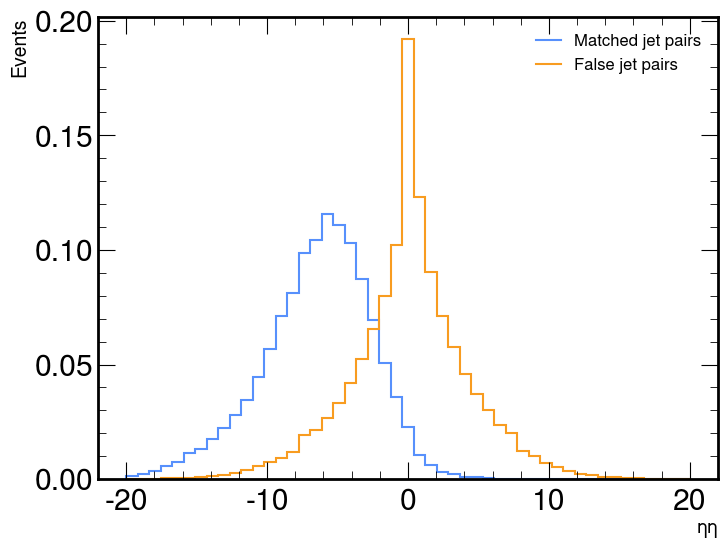

In [51]:
hist1, bins1 = np.histogram(two_part_events[:, 0].eta * two_part_events[:, 1].eta, bins = np.linspace(-20, 20, 50))
hist2, bins2 = np.histogram(ak.flatten(v1.eta * v2.eta), bins = np.linspace(-20, 20, 50))
#hist3, bins3 = np.histogram(vbf_vecs[:, 0].eta * vbf_vecs[:, 1].eta, bins = np.linspace(-20, 10, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet',
#    density=True,
#)

ax.set_xlabel('$\\eta  \\eta$', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)

In [39]:
# max, min etas

matched_jets_max_etas = ak.max(abs(matched_pairs.eta[ak.num(matched_pairs) > 0]), axis=1)
matched_jets_min_etas = ak.min(abs(matched_pairs.eta[ak.num(matched_pairs) > 0]), axis=1)

higher_eta_mask = abs(v1.eta) > abs(v2.eta)
false_pair_max_eta = ak.where(higher_eta_mask, v1, v2)
false_pair_min_eta = ak.where(higher_eta_mask, v2, v1)

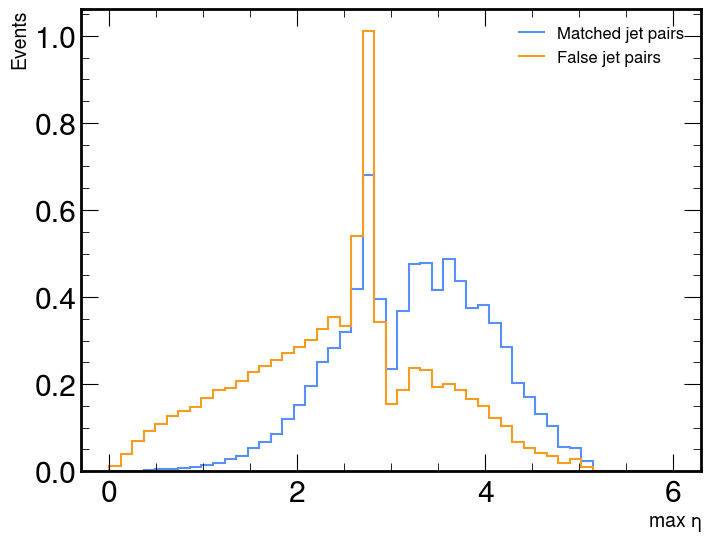

In [43]:
hist1, bins1 = np.histogram(matched_jets_max_etas, bins = np.linspace(0, 6, 50))
hist2, bins2 = np.histogram(ak.flatten(abs(false_pair_max_eta.eta)), bins = np.linspace(0, 6, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

ax.set_xlabel('max $ \\eta $', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)

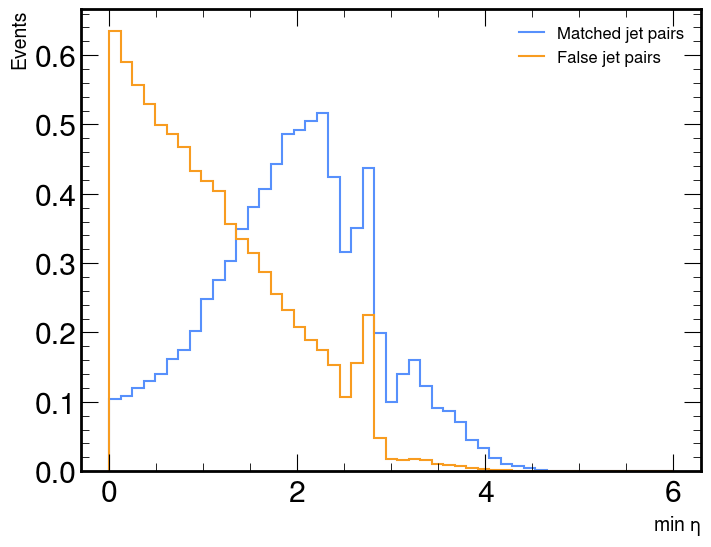

In [44]:
hist1, bins1 = np.histogram(matched_jets_min_etas, bins = np.linspace(0, 6, 50))
hist2, bins2 = np.histogram(ak.flatten(abs(false_pair_min_eta.eta)), bins = np.linspace(0, 6, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pairs',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pairs',
    density=True,
)

ax.set_xlabel('min $ \\eta $', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)

# B-tags

## DeepJet

In [40]:
tj1, tj2 = ak.unzip(novec_pairs2)
btag1 = ak.flatten(tj1.btagDeepFlavB)
btag2 = ak.flatten(tj2.btagDeepFlavB)
trainingjet_btag_sum = btag1 + btag2

In [41]:
matched_jet_btags = matched_novec_pairs.btagDeepFlavB[ak.num(matched_novec_pairs.btagDeepFlavB) > 0]
vbfjet_btag_sum = ak.sum(vbfhh.VBFJet.btagDeepFlavB, axis=1)

In [42]:
# max btag

higher_btag_mask = tj1.btagDeepFlavB > tj2.btagDeepFlavB
higher_btag_novec = ak.where(higher_btag_mask, tj1, tj2)
lower_btag_novec = ak.where(higher_btag_mask, tj2, tj1)

matched_jet_max_btag_idx = ak.argmax(matched_novec_pairs.btagDeepFlavB[ak.num(matched_novec_pairs.btagDeepFlavB) > 0], axis=1)
matched_novec_loc_idx = ak.local_index(matched_novec_pairs[ak.num(matched_novec_pairs) > 0], axis=1)
max_btag_matched_jet = matched_novec_pairs[ak.num(matched_novec_pairs) > 0][matched_jet_max_btag_idx == matched_novec_loc_idx]
min_btag_matched_jet = matched_novec_pairs[ak.num(matched_novec_pairs) > 0][~(matched_jet_max_btag_idx == matched_novec_loc_idx)]

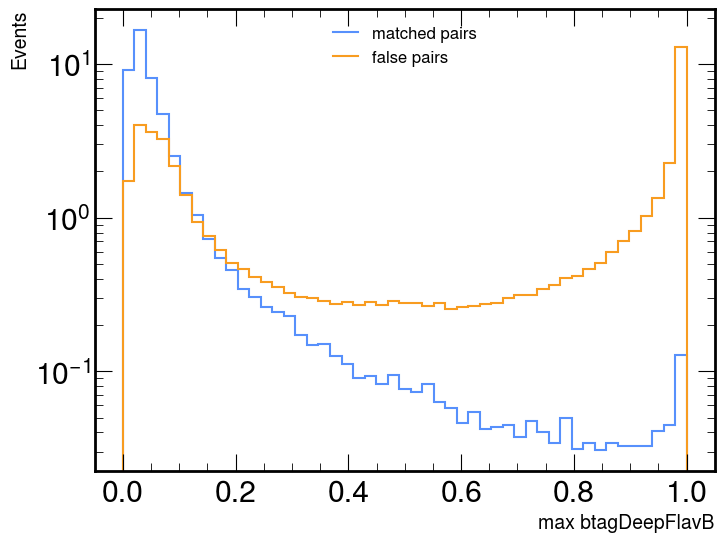

In [48]:
hist1, bins1 = np.histogram(max_btag_matched_jet.btagDeepFlavB, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(higher_btag_novec.btagDeepFlavB), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('max btagDeepFlavB', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
plt.yscale('log')

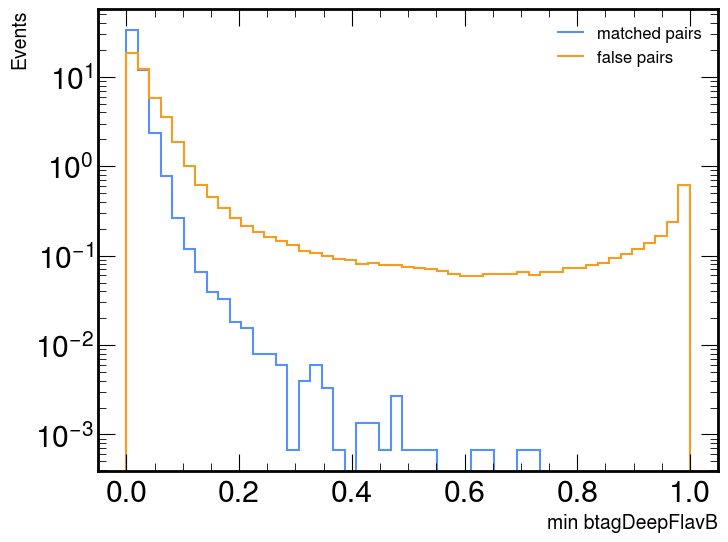

In [49]:
hist1, bins1 = np.histogram(min_btag_matched_jet.btagDeepFlavB, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(lower_btag_novec.btagDeepFlavB), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('min btagDeepFlavB', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
plt.yscale('log')

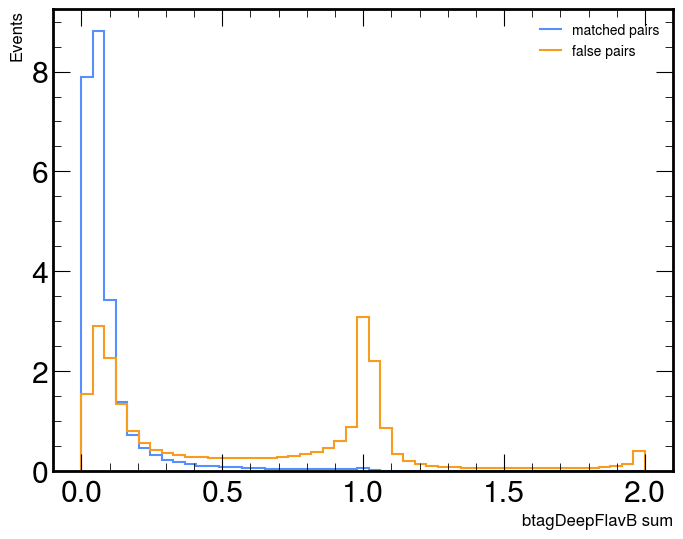

In [50]:
hist1, bins1 = np.histogram(ak.sum(matched_jet_btags, axis = 1), bins = np.linspace(0, 2, 50))
hist2, bins2 = np.histogram(trainingjet_btag_sum, bins = np.linspace(0, 2, 50))
#hist3, bins3 = np.histogram(vbfjet_btag_sum, bins = np.linspace(0, 2, 50))
fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)
#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBF jets',
#    density=True,
#)

ax.set_xlabel('btagDeepFlavB sum', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)
#plt.yscale('log')

#fig.tight_layout()
#fig.savefig("plots/08_DeepFlav_sum.png", dpi=150)

## ParticleNet

In [43]:
matched_btagPNet = matched_novec_pairs.btagPNetB[ak.num(matched_novec_pairs.btagPNetB) > 0]

matched_pair_btagPNetB_sum = matched_btagPNet[:, 0] + matched_btagPNet[:, 1]
false_pair_btagPNetB_sum = ak.flatten(tj1.btagPNetB + tj2.btagPNetB)

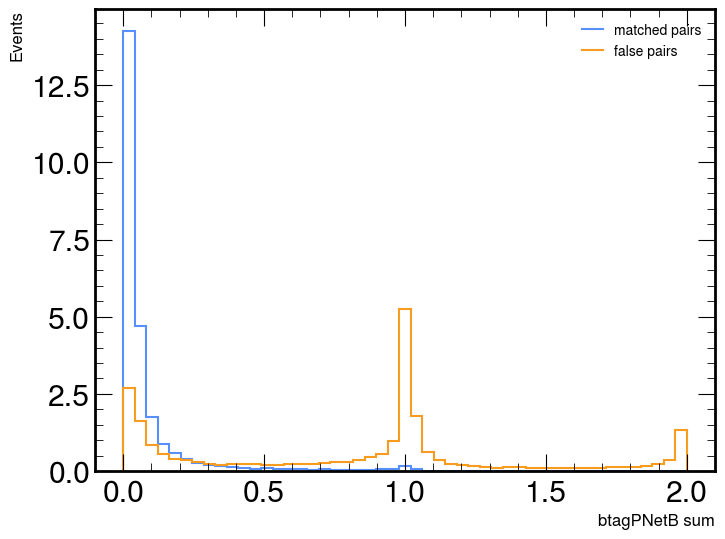

In [52]:
hist1, bins1 = np.histogram(matched_btagPNet[:, 0] + matched_btagPNet[:, 1], bins = np.linspace(0, 2, 50))
hist2, bins2 = np.histogram(ak.flatten(tj1.btagPNetB + tj2.btagPNetB), bins = np.linspace(0, 2, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('btagPNetB sum', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)
#plt.yscale('log')

#fig.tight_layout()
#fig.savefig("plots/09_PNet_sum.png", dpi=150)

In [44]:
higher_btagPNet_mask = tj1.btagPNetB > tj2.btagPNetB
higher_btagPNet_novec = ak.where(higher_btagPNet_mask, tj1, tj2)
lower_btagPNet_novec = ak.where(higher_btagPNet_mask, tj2, tj1)

matched_jet_max_btagPNet_idx = ak.argmax(matched_novec_pairs.btagPNetB[ak.num(matched_novec_pairs.btagPNetB) > 0], axis=1)
matched_novec_loc_idx = ak.local_index(matched_novec_pairs[ak.num(matched_novec_pairs) > 0], axis=1)
max_btagPNet_matched_jet = matched_novec_pairs[ak.num(matched_novec_pairs) > 0][matched_jet_max_btagPNet_idx == matched_novec_loc_idx]
min_btagPNet_matched_jet = matched_novec_pairs[ak.num(matched_novec_pairs) > 0][~(matched_jet_max_btagPNet_idx == matched_novec_loc_idx)]

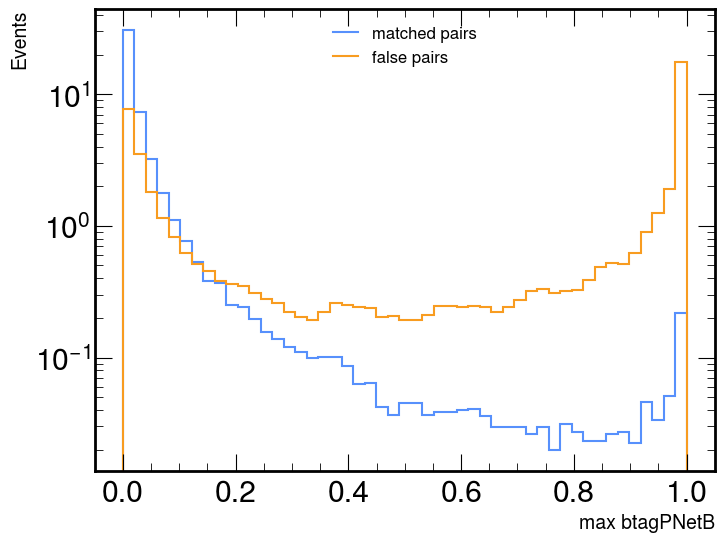

In [54]:
hist1, bins1 = np.histogram(max_btagPNet_matched_jet.btagPNetB, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(higher_btagPNet_novec.btagPNetB), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('max btagPNetB', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
plt.yscale('log')

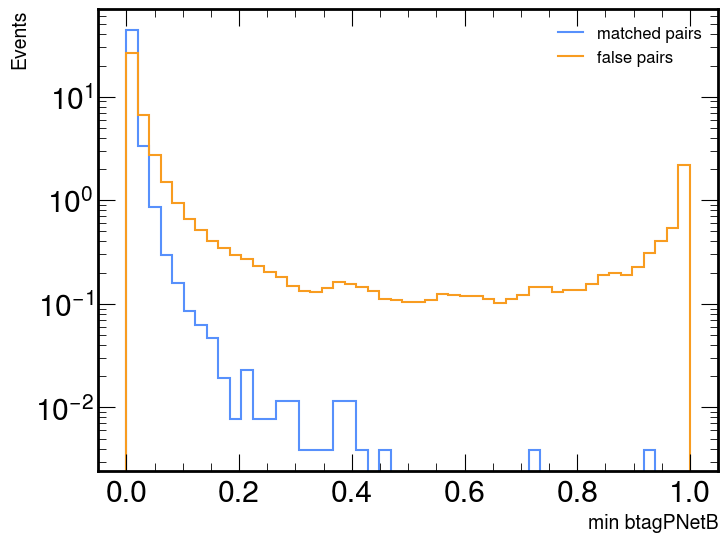

In [55]:
hist1, bins1 = np.histogram(min_btagPNet_matched_jet.btagPNetB, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(lower_btagPNet_novec.btagPNetB), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('min btagPNetB', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
plt.yscale('log')

# hhbtag

In [45]:
higher_hhbtag_mask = tj1.hhbtag > tj2.hhbtag
higher_hhbtag_novec = ak.where(higher_hhbtag_mask, tj1, tj2)
lower_hhbtag_novec = ak.where(higher_hhbtag_mask, tj2, tj1)

matched_jet_max_hhbtag = ak.max(matched_novec_pairs.hhbtag[ak.num(matched_novec_pairs) > 0], axis=1)
matched_jet_min_hhbtag = ak.min(matched_novec_pairs.hhbtag[ak.num(matched_novec_pairs) > 0], axis=1)

# sum
false_pair_hhbtag_sum = tj1.hhbtag + tj2.hhbtag
matched_pair_hhbtag_sum = ak.sum(matched_novec_pairs.hhbtag[ak.num(matched_novec_pairs)>0], axis=1)

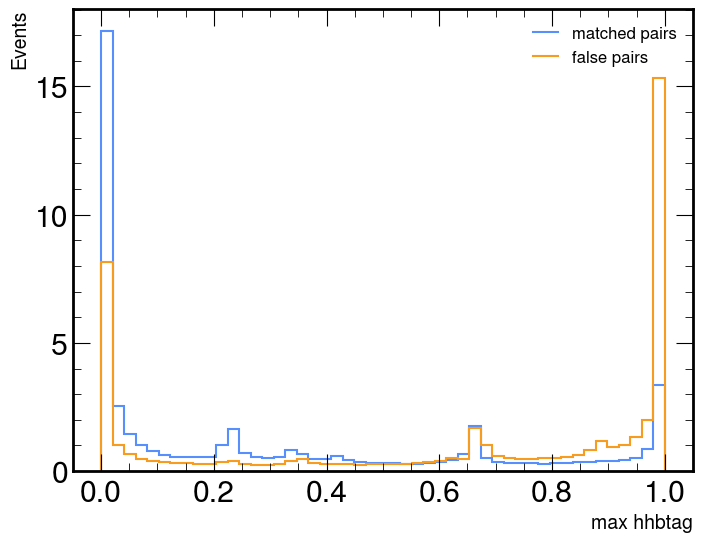

In [57]:
hist1, bins1 = np.histogram(matched_jet_max_hhbtag, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(higher_hhbtag_novec.hhbtag), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('max hhbtag', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
#plt.yscale('log')

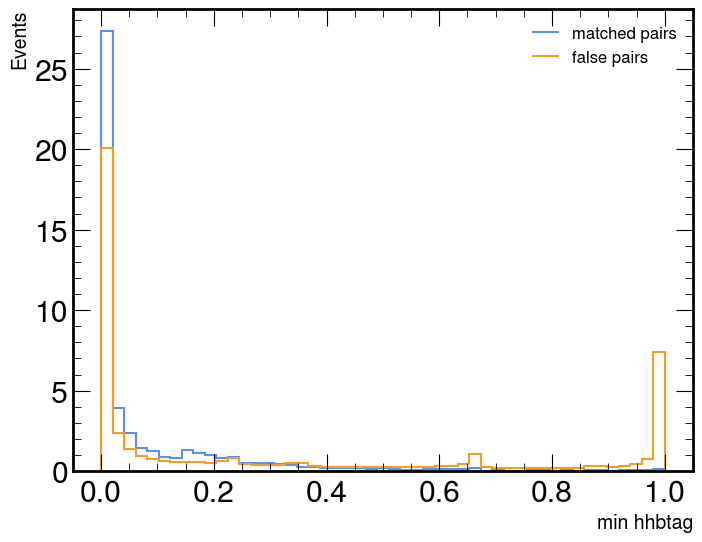

In [58]:
hist1, bins1 = np.histogram(matched_jet_min_hhbtag, bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram(ak.flatten(lower_hhbtag_novec.hhbtag), bins = np.linspace(0, 1, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('min hhbtag', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
#plt.yscale('log')

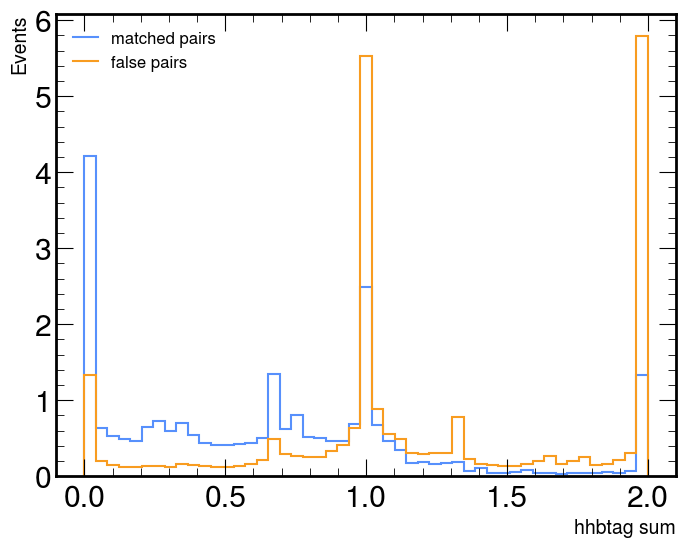

In [59]:
hist1, bins1 = np.histogram(matched_pair_hhbtag_sum, bins = np.linspace(0, 2, 50))
hist2, bins2 = np.histogram(ak.flatten(false_pair_hhbtag_sum), bins = np.linspace(0, 2, 50))

fig, ax = plt.subplots(figsize=(8,6))
hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='matched pairs',
    density=True,
)
hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='false pairs',
    density=True,
)


ax.set_xlabel('hhbtag sum', fontsize=14)
ax.set_ylabel('Events', fontsize=14)
ax.legend(fontsize=12)
#plt.yscale('log')

# E

In [46]:
matched_jet_sum_energy = sum_matched_jet_vecs.energy
vec_pair_sum_energy = (v1 + v2).energy
vbf_jet_sum_energy = sum_vbf_jet_vecs.energy

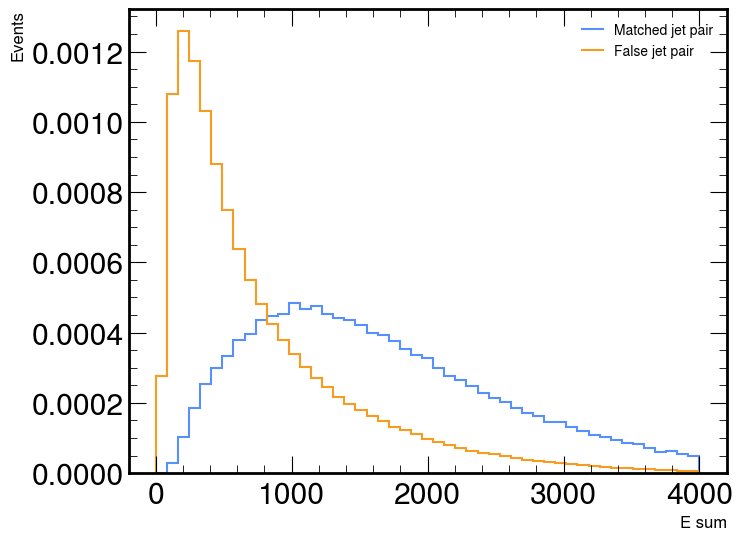

In [61]:
hist1, bins1 = np.histogram(matched_jet_sum_energy, bins = np.linspace(0, 4000, 50))
hist2, bins2 = np.histogram(ak.flatten(vec_pair_sum_energy), bins = np.linspace(0, 4000, 50))
#hist3, bins3 = np.histogram(vbf_jet_sum_energy, bins = np.linspace(0, 6000, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair E',
#    density=True,
#)

ax.set_xlabel('E sum', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/10_sum_e.png", dpi=150)

In [47]:
higher_e_mask = v1.energy > v2.energy
higher_e_vec_pairs = ak.where(higher_e_mask, v1, v2)
lower_e_vec_pairs = ak.where(higher_e_mask, v2, v1)

higher_e_mask_vbf = vbf_vecs[:, 0].energy > vbf_vecs[:, 1].energy
higher_e_vbfjet = ak.where(higher_e_mask_vbf, vbf_vecs[:, 0], vbf_vecs[:, 1])
lower_e_vbfjet = ak.where(higher_e_mask_vbf, vbf_vecs[:, 1], vbf_vecs[:, 0])

higher_e_mask_matched = two_part_events[:, 0].energy > two_part_events[:, 1].energy
higher_e_matched_jet = ak.where(higher_e_mask_matched, two_part_events[:, 0], two_part_events[:, 1])
lower_e_matched_jet = ak.where(higher_e_mask_matched, two_part_events[:, 1], two_part_events[:, 0])


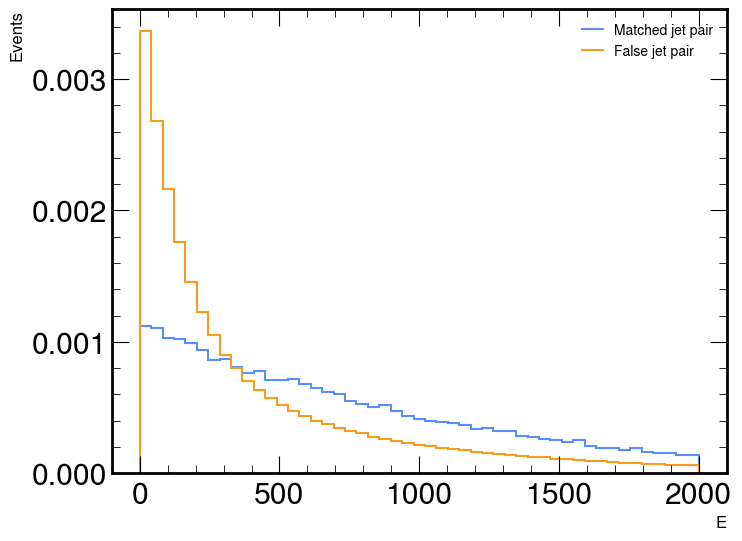

In [63]:
# high e - low e

hist1, bins1 = np.histogram(higher_e_matched_jet.energy - lower_e_matched_jet.energy, bins = np.linspace(0, 2000, 50))
hist2, bins2 = np.histogram(ak.flatten(higher_e_vec_pairs.energy) - ak.flatten(lower_e_vec_pairs.energy), bins = np.linspace(0, 2000, 50))
#hist3, bins3 = np.histogram(higher_e_vbfjet.energy - lower_e_vbfjet.energy, bins = np.linspace(0, 2000, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair',
#    density=True,
#)

ax.set_xlabel('E', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/11_delta_E.png", dpi=150)

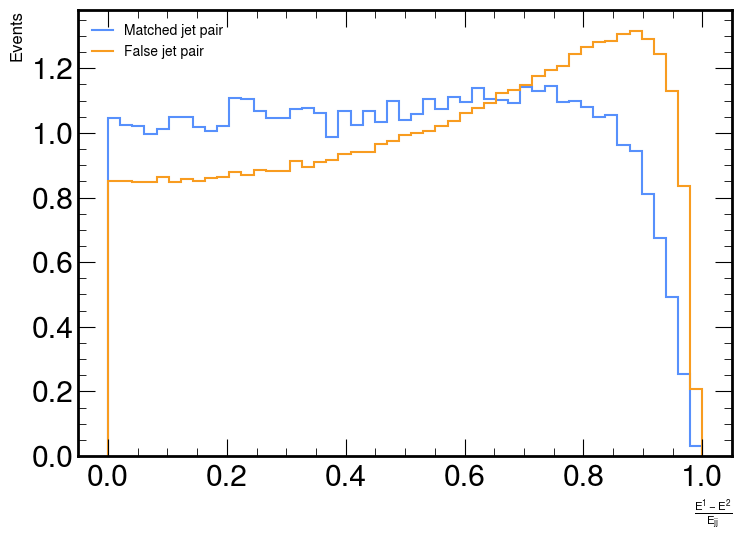

In [64]:
# (high e - low e) / (sum.e)

hist1, bins1 = np.histogram((higher_e_matched_jet.energy - lower_e_matched_jet.energy) / (matched_jet_sum_energy), bins = np.linspace(0, 1, 50))
hist2, bins2 = np.histogram((ak.flatten(higher_e_vec_pairs.energy) - ak.flatten(lower_e_vec_pairs.energy)) / (ak.flatten(vec_pair_sum_energy)), bins = np.linspace(0, 1, 50))
#hist3, bins3 = np.histogram((higher_e_vbfjet.energy - lower_e_vbfjet.energy) / (vbf_jet_sum_energy), bins = np.linspace(0, 1, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair',
#    density=True,
#)

ax.set_xlabel('$ \\frac{E^1 - E^2}{E_{jj}}$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)
#fig.savefig('/mnt/c/Users/miina/Desktop/test.pdf')

fig.tight_layout()
fig.savefig("plots/12_ee.png", dpi=150)

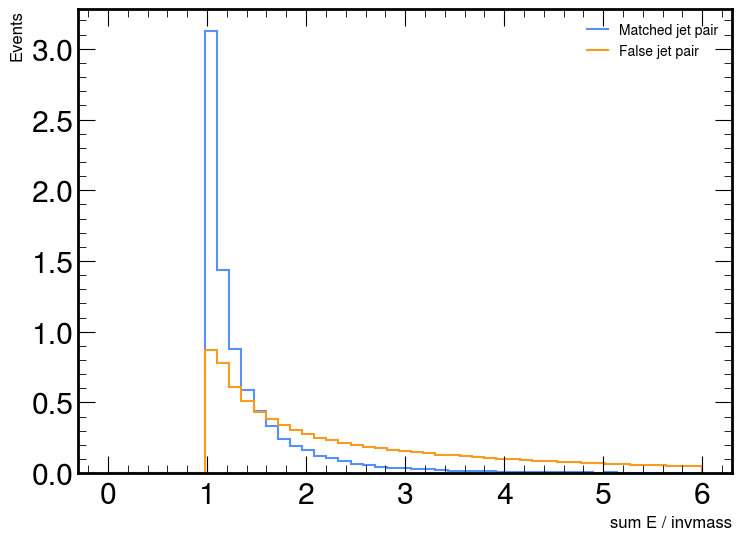

In [48]:
matched_pair_e_invmass = (matched_jet_sum_energy) / (matched_jet_inv_mass)
false_pair_e_invmass = (ak.flatten(vec_pair_sum_energy)) / (ak.flatten(vec_pairs_inv_mass))

hist1, bins1 = np.histogram((matched_jet_sum_energy) / (matched_jet_inv_mass), bins = np.linspace(0, 6, 50))
hist2, bins2 = np.histogram((ak.flatten(vec_pair_sum_energy)) / (ak.flatten(vec_pairs_inv_mass)), bins = np.linspace(0, 6, 50))
#hist3, bins3 = np.histogram((vbf_jet_sum_energy) / (vbf_jet_invariant_masses), bins = np.linspace(0, 6, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet pair',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet pair',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair',
#    density=True,
#)

ax.set_xlabel('sum E / invmass', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/15_E_invmass.png", dpi=150)

# min $\Delta$ R

esimene jet matchitud paaridest 

In [49]:
jet1_deltaR_trainingjets = two_part_events[:, 0].deltaR(trainingjet_vecs[num_parts_in_filtered == 2])
jet2_deltaR_trainingjets = two_part_events[:, 1].deltaR(trainingjet_vecs[num_parts_in_filtered == 2])

In [50]:
# nii et kordusi poleks, võtan vastava jeti jälja
jet1_deltaR_jets = jet1_deltaR_trainingjets[jet1_deltaR_trainingjets != 0]
jet2_deltaR_jets = jet2_deltaR_trainingjets[jet2_deltaR_trainingjets != 0]

In [51]:
jet1_min_deltaR = ak.min(jet1_deltaR_jets, axis=1)
jet2_min_deltaR = ak.min(jet2_deltaR_jets, axis=1)

Text(0, 1, 'Events')

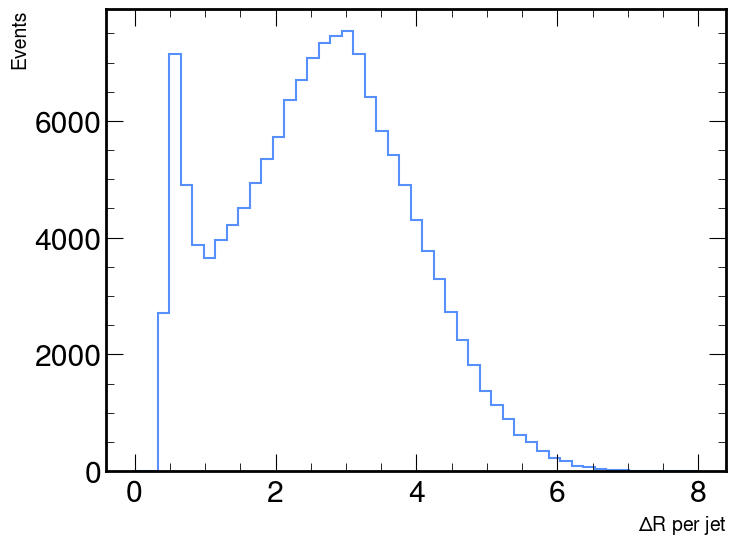

In [69]:
hist1, bins1 = np.histogram(ak.concatenate([jet1_min_deltaR, jet2_min_deltaR]), bins = np.linspace(0, 8, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
)

ax.set_xlabel('$\\Delta R$ per jet', fontsize=14)
ax.set_ylabel('Events', fontsize=14)

In [52]:
electron_vecs = ak.zip(
    {
        "pt": vbfhh["Electron"]["pt"],
        "eta": vbfhh["Electron"]["eta"],
        "phi": vbfhh["Electron"]["phi"],
        "mass": vbfhh["Electron"]["mass"],
    },
    with_name="Momentum4D"
)

In [53]:
jet1_deltaR_electrons = two_part_events[:, 0].deltaR(electron_vecs[num_parts_in_filtered == 2])
jet2_deltaR_electrons = two_part_events[:, 1].deltaR(electron_vecs[num_parts_in_filtered == 2])

# siia ka min tingimus, kuna muidu jama
jet1_min_deltaR_electrons = ak.min(jet1_deltaR_electrons, axis=1)
jet2_min_deltaR_electrons = ak.min(jet2_deltaR_electrons, axis=1)

Text(0, 1, 'Events')

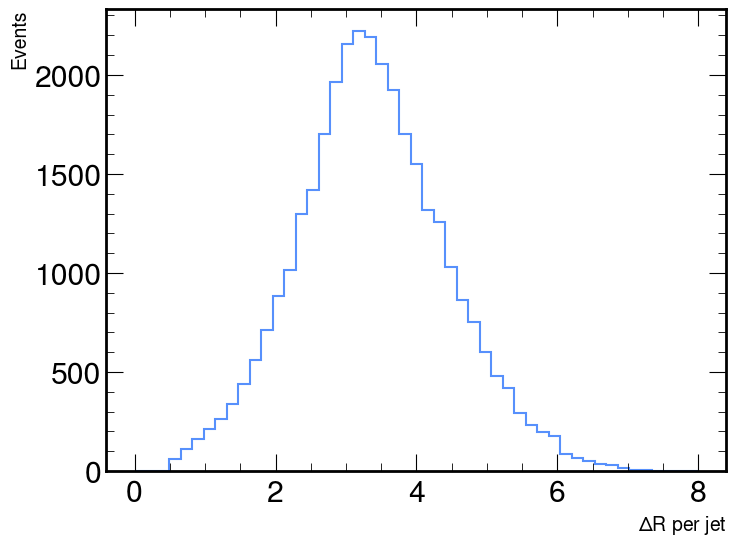

In [61]:
hist1, bins1 = np.histogram(ak.concatenate([jet1_min_deltaR_electrons, jet2_min_deltaR_electrons]), bins = np.linspace(0, 8, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
)

ax.set_xlabel('$\\Delta R$ per jet', fontsize=14)
ax.set_ylabel('Events', fontsize=14)

In [54]:
muon_vecs = ak.zip(
    {
        "pt": vbfhh["Muon"]["pt"],
        "eta": vbfhh["Muon"]["eta"],
        "phi": vbfhh["Muon"]["phi"],
        "mass": vbfhh["Muon"]["mass"],
    },
    with_name="Momentum4D"
)

In [55]:
jet1_deltaR_muons = two_part_events[:, 0].deltaR(muon_vecs[num_parts_in_filtered == 2])
jet2_deltaR_muons = two_part_events[:, 1].deltaR(muon_vecs[num_parts_in_filtered == 2])

jet1_min_deltaR_muons = ak.min(jet1_deltaR_muons, axis=1)
jet2_min_deltaR_muons = ak.min(jet2_deltaR_muons, axis=1)

Text(0, 1, 'Events')

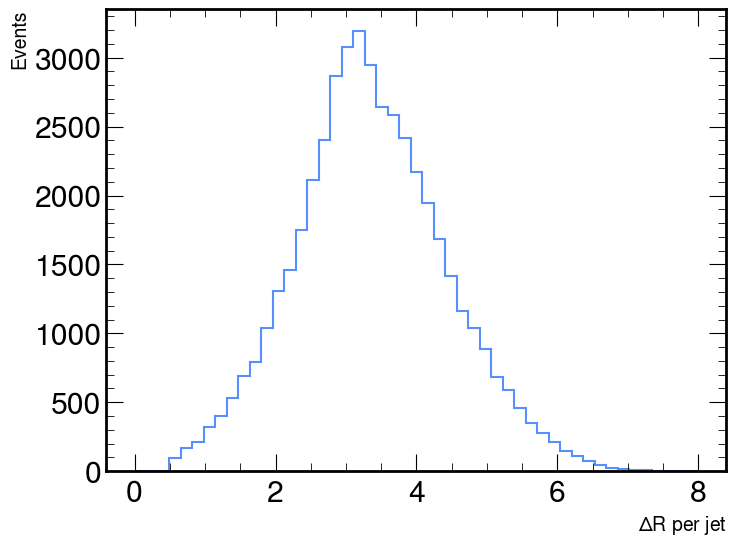

In [64]:
hist1, bins1 = np.histogram(ak.concatenate([jet1_min_deltaR_muons, jet2_min_deltaR_muons]), bins = np.linspace(0, 8, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
)

ax.set_xlabel('$\\Delta R$ per jet', fontsize=14)
ax.set_ylabel('Events', fontsize=14)

# flags?

In [78]:
# electron tau

is_electron_event = ak.num(vbfhh.Electron)>0
# muon tau
is_muon_event = ak.where(is_electron_event & (ak.num(vbfhh.Muon)>0), ~(ak.num(vbfhh.Muon)>0), (ak.num(vbfhh.Muon)>0))

# two taus per event?
is_tau_event = ak.num(vbfhh.Tau)>1

In [57]:
matched_pair_electron_event = is_electron_event[num_parts_in_filtered == 2]
matched_pair_muon_event = is_muon_event[num_parts_in_filtered == 2]
matched_pair_tau_event = is_tau_event[num_parts_in_filtered == 2]

In [58]:
false_pair_electron_event, _ = ak.broadcast_arrays(is_electron_event, vec_pairs)
false_pair_muon_event, _ = ak.broadcast_arrays(is_muon_event, vec_pairs)
false_pair_tau_event, _ = ak.broadcast_arrays(is_tau_event, vec_pairs)

# Event $p_T$ sum

In [59]:
# pT sum per event

event_pt = ak.sum(trainingjet_vecs.pt, axis=1)

matched_pair_event_pt = event_pt[num_parts_in_filtered == 2]
false_pair_event_pt, _ = ak.broadcast_arrays(event_pt, vec_pairs)

Text(0, 1, 'Events')

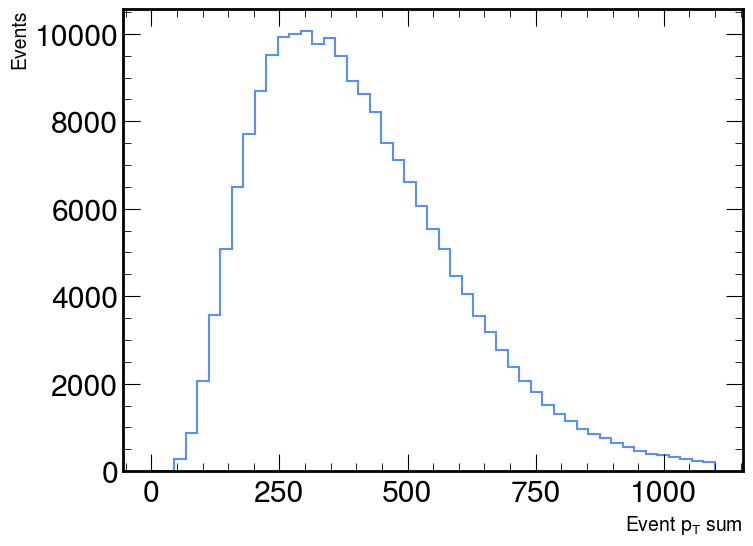

In [73]:
hist1, bins1 = np.histogram(event_pt, bins = np.linspace(0, 1100, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
)

ax.set_xlabel('Event $p_T$ sum', fontsize=14)
ax.set_ylabel('Events', fontsize=14)

# PuppiMET

In [68]:
vbfhh.PuppiMET.covXY
matched_pair_PuppiMET_covXY = vbfhh.PuppiMET.covXY[num_parts_in_filtered == 2]  # ???
false_pair_PuppiMET_covXY, _ = ak.broadcast_arrays(vbfhh.PuppiMET.covXY, vec_pairs)   # ???

In [61]:
matched_pair_PuppiMET_pt = vbfhh.PuppiMET.pt[num_parts_in_filtered == 2]
false_pair_PuppiMET_pt, _ = ak.broadcast_arrays(vbfhh.PuppiMET.pt, vec_pairs)

# Event energy sum

In [62]:
event_energy = ak.sum(trainingjet_vecs.energy, axis=1)

matched_pair_event_energy = event_energy[num_parts_in_filtered == 2]
false_pair_event_energy, _ = ak.broadcast_arrays(event_energy, vec_pairs)

Text(0, 1, 'Events')

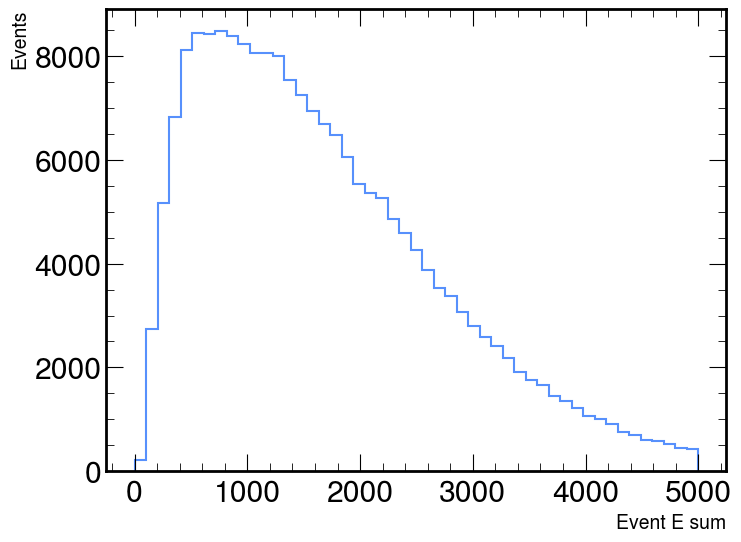

In [76]:
hist1, bins1 = np.histogram(event_energy, bins = np.linspace(0, 5000, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
)

ax.set_xlabel('Event E sum', fontsize=14)
ax.set_ylabel('Events', fontsize=14)

# Individual Jet $p_T$ and $\eta$

In [63]:
non_matched_trainingjet_mask = G1_combined_mask | G2_combined_mask
non_genmatch = trainingjets_novec[~non_matched_trainingjet_mask]  # siin ära võetud ka genmatchitud üksikud jetid
non_matched_trainingjets = ak.where(num_parts_in_filtered == 2, non_genmatch, trainingjets_novec) # siin ära võetud ainult matchitud paarid

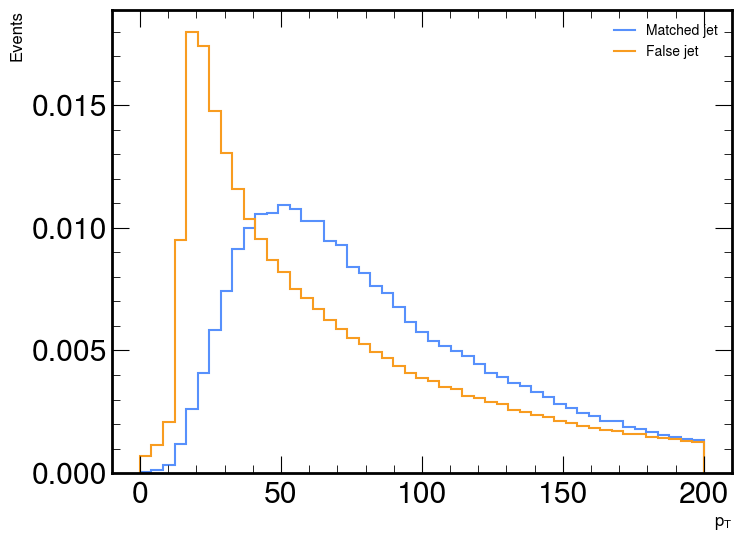

In [140]:
# individual pts

hist1, bins1 = np.histogram(ak.flatten(matched_pairs.pt), bins = np.linspace(0, 200, 50))
hist2, bins2 = np.histogram(ak.flatten(non_matched_trainingjets.pt), bins = np.linspace(0, 200, 50))
#hist3, bins3 = np.histogram(ak.flatten(vbfhh.VBFJet.pt), bins = np.linspace(0, 200, 50))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet ',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair',
#    density=True,
#)

ax.set_xlabel('$p_T$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/13_pt.png", dpi=150)

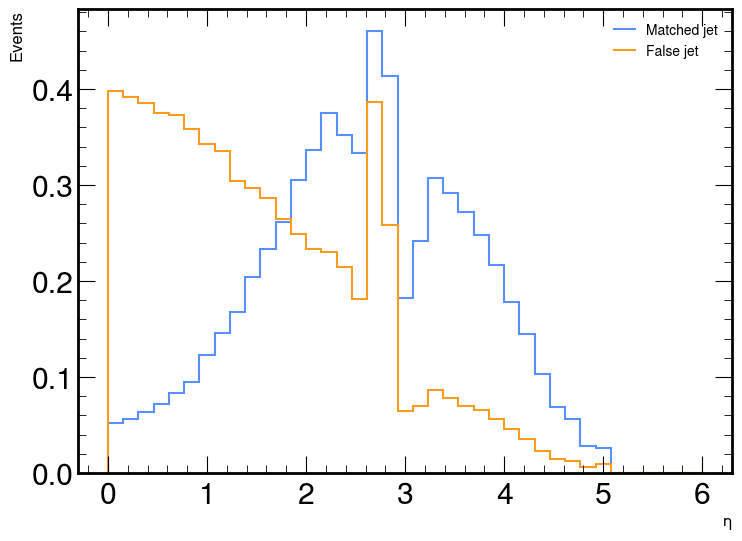

In [75]:
# individual etas

hist1, bins1 = np.histogram(abs(ak.flatten(matched_pairs.eta)), bins = np.linspace(0, 6, 40))
hist2, bins2 = np.histogram(abs(ak.flatten(non_matched_trainingjets.eta)), bins = np.linspace(0, 6, 40))
#hist3, bins3 = np.histogram(abs(ak.flatten(vbfhh.VBFJet.eta)), bins = np.linspace(0, 6, 40))
fig, ax = plt.subplots(figsize=(8,6))

hep.histplot(
    (hist1, bins1),
    histtype='step',
    label='Matched jet',
    density=True,
)

hep.histplot(
    (hist2, bins2),
    histtype='step',
    label='False jet',
    density=True,
)

#hep.histplot(
#    (hist3, bins3),
#    histtype='step',
#    label='VBFJet pair',
#    density=True,
#)

ax.set_xlabel('$\\eta$', fontsize=12)
ax.set_ylabel('Events', fontsize=12)
ax.legend(fontsize=10)

fig.tight_layout()
fig.savefig("plots/14_eta.png", dpi=150)

# ML

Valitud paarid:

Valed jettide paarid eventidest, kus vähemalt 4 jetti. Valede paaride seas pole matchitud jette.
Kõik matchitud paarid (ka eventidest, kus alla 4 jeti. y-s valed jetid ja peale neid matchitud jetid.

In [64]:
pairs_to_zero = ak.Array([0] * len(ak.flatten(vec_pairs[ak.num(vec_pairs) > 0])))
matched_to_one = ak.Array([1] * len(matched_pairs[ak.num(matched_pairs) > 0]))

y = ak.concatenate([pairs_to_zero, matched_to_one])

In [69]:
false_pair_PNet_sum = ak.flatten(tj1.btagPNetB + tj2.btagPNetB)
matched_pair_PNet_sum = matched_btagPNet[:, 0] + matched_btagPNet[:, 1]

all_PNet_sums = ak.concatenate([false_pair_PNet_sum, matched_pair_PNet_sum])

In [70]:
# muonid ja elektronid (per event) paaride kohta

all_electron_event_pairs = ak.concatenate([ak.flatten(false_pair_electron_event), matched_pair_electron_event])
all_muon_event_pairs = ak.concatenate([ak.flatten(false_pair_muon_event), matched_pair_muon_event])

In [71]:
# delta eta v eta*eta

false_jet_pair_etaeta = ak.flatten(v1.eta * v2.eta)
matched_jet_pair_etaeta = two_part_events[:, 0].eta * two_part_events[:, 1].eta

In [72]:
all_inv_masses = ak.concatenate([ak.flatten(vec_pairs_inv_mass), matched_jet_inv_mass])
all_delta_etas = ak.concatenate([ak.flatten(trainingjet_pair_delta_eta), matched_jet_delta_eta])
all_etaetas = ak.concatenate([false_jet_pair_etaeta, matched_jet_pair_etaeta])
all_deltaRs = ak.concatenate([ak.flatten(false_pair_deltaR), matched_pair_deltaR])
all_btagDeepFlavB_sums = ak.concatenate([trainingjet_btag_sum, ak.sum(matched_jet_btags, axis = 1)])
all_btagPNetB_sums = ak.concatenate([false_pair_btagPNetB_sum, matched_pair_btagPNetB_sum])
akk_hhbtag_sums = ak.concatenate([ak.flatten(false_pair_hhbtag_sum), matched_pair_hhbtag_sum])
all_delta_energy = ak.concatenate([ak.flatten(higher_e_vec_pairs.energy) - ak.flatten(lower_e_vec_pairs.energy), higher_e_matched_jet.energy - lower_e_matched_jet.energy])
all_e_invmass = ak.concatenate([false_pair_e_invmass, matched_pair_e_invmass])
all_min_pts = ak.concatenate([ak.flatten(false_pair_min_pt.pt), matched_jets_min_pt])
all_event_pts = ak.concatenate([ak.flatten(false_pair_event_pt), matched_pair_event_pt])
all_event_energy = ak.concatenate([ak.flatten(false_pair_event_energy), matched_pair_event_energy])
all_PuppiMET_covXY = ak.concatenate([ak.flatten(false_pair_PuppiMET_covXY), matched_pair_PuppiMET_covXY])  # ???
all_PuppiMET_pt = ak.concatenate([ak.flatten(false_pair_PuppiMET_pt), matched_pair_PuppiMET_pt])   # ???

In [81]:
X = ak.concatenate([ak.singletons(all_inv_masses), ak.singletons(all_etaetas), ak.singletons(all_btagPNetB_sums), ak.singletons(all_delta_energy), ak.singletons(all_event_energy)], axis=1)

In [82]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import roc_curve, auc

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42) # random_state peaks fikseerima splittimise
y_train = np.array(y_train)
y_test = np.array(y_test)

In [100]:
#100000/sum(w_train[(y_train==1)])

np.float64(0.9999999999990976)

In [81]:
w_train = np.ones_like(np.array(y_train), dtype=np.float64)
n_true = sum(w_train[y_train==1])
n_false = sum(w_train[y_train==0])

w_true = 100000/n_true
w_false = 100000/n_false

w_train[y_train==1] = w_true
w_train[y_train==0] = w_false

w_test = np.ones_like(np.array(y_test), dtype=np.float64)
n_true = sum(w_test[y_test==1])
n_false = sum(w_test[y_test==0])

w_true = 100000/n_true
w_false = 100000/n_false

w_test[y_test==1] = w_true
w_test[y_test==0] = w_false

In [82]:
bst = XGBRegressor()

In [83]:
bst.fit(X_train, y_train, sample_weight=w_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [84]:
preds_test = bst.predict(X_test)
preds_train = bst.predict(X_train)

In [85]:
y_test=np.array(y_test)
y_train=np.array(y_train)

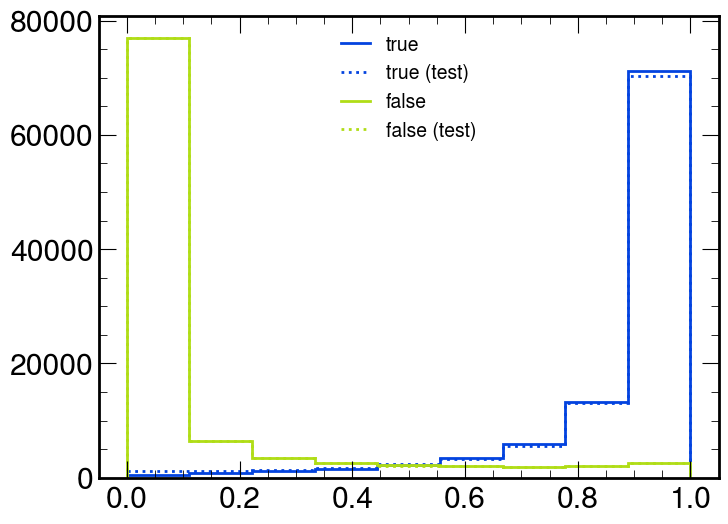

In [86]:
preds_test=np.fmax(0., np.fmin(1., preds_test))
preds_train=np.fmax(0., np.fmin(1., preds_train))

hist1_train, bins1_train = np.histogram(preds_train[y_train==1], bins = np.linspace(0, 1, 10), weights=w_train[y_train==1])
hist2_train, bins2_train = np.histogram(preds_train[y_train==0], bins = np.linspace(0, 1, 10), weights=w_train[y_train==0])

hist1_test, bins1_test = np.histogram(preds_test[y_test==1], bins = np.linspace(0, 1, 10), weights=w_test[y_test==1])
hist2_test, bins2_test = np.histogram(preds_test[y_test==0], bins = np.linspace(0, 1, 10), weights=w_test[y_test==0])
fig, ax = plt.subplots(figsize=(8,6))



hep.histplot(
    (hist1_train, bins1_train),
    histtype='step',
    color = '#0343df',
    label='true',
    density=False,
    linewidth=2,
)

hep.histplot(
    (hist1_test, bins1_test),
    histtype='step',
    label='true (test)',
    density=False,
    color = '#0343df',
    linestyle = ':',
    linewidth=2,
)

hep.histplot(
    (hist2_train, bins2_train),
    histtype='step',
    label='false',
    color = '#b0dd16',
    density=False,
    linewidth=2,
)

hep.histplot(
    (hist2_test, bins2_test),
    histtype='step',
    label='false (test)',
    density=False,
    linewidth=2,
    color = '#b0dd16',
    linestyle = ':',
)

ax.legend(fontsize=14)

In [74]:
# vaata neid, kus preds alla nulli või üle ühe. veits kahtlane

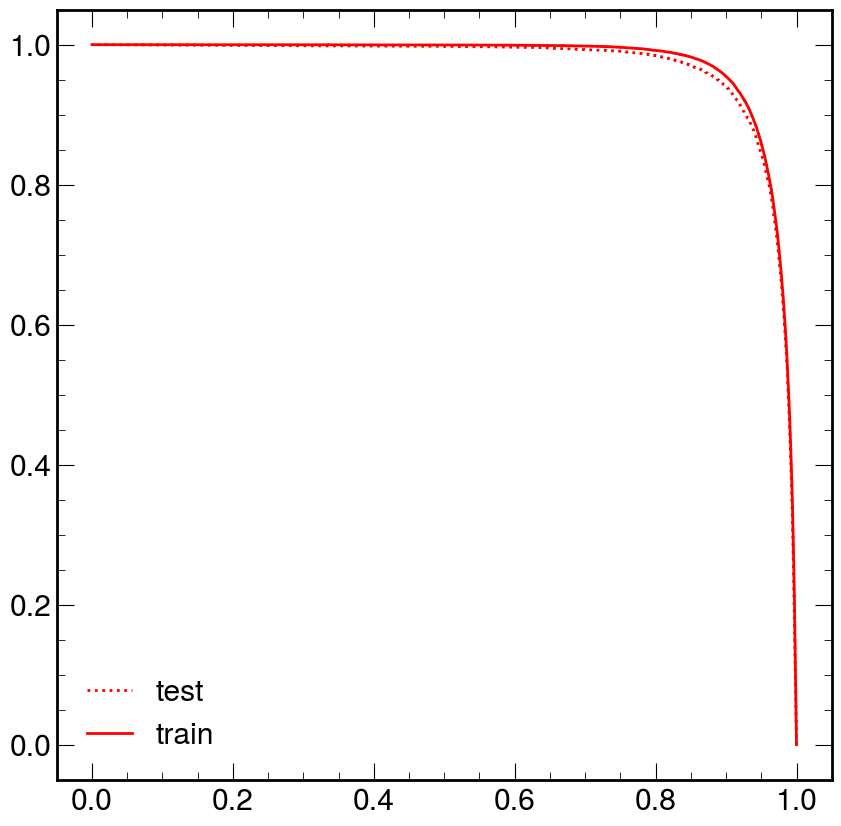

In [87]:
fpr1, tpr1, _ = roc_curve(y_test, preds_test)
fpr2, tpr2, _ = roc_curve(y_train, preds_train)
plt.plot(1-fpr1, tpr1, label='test', color='red', linewidth=2, linestyle=':')
plt.plot(1-fpr2, tpr2, label='train', color='red', linewidth=2)
roc_auc_test = auc(1-fpr1, tpr1)
roc_auc_train = auc(1-fpr2, tpr2)
plt.legend()

In [88]:
roc_auc_test

np.float64(0.9705654291990233)

In [89]:
roc_auc_train

np.float64(0.9750399237881082)